In [1]:
# used to change filepaths
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

# import Image from PIL
from PIL import Image



from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# import train_test_split from sklearn's model selection module

from sklearn.model_selection import train_test_split

# import SVC from sklearn's svm module

from sklearn.svm import SVC

# import accuracy_score from sklearn's metrics module
from sklearn.metrics import roc_curve, auc, accuracy_score

In [3]:
labels = pd.read_csv("datasets/labels.csv", index_col=0)

def get_image(row_id, root="datasets/images/train/"):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    filename = "{}.jpg".format(row_id)
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    return np.array(img)


def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = rgb2grey(img)
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack((color_features, hog_features))
    return flat_features

def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img_id in label_dataframe.index:
        # load image
        img = get_image(img_id)
        # get features for image
        image_features = create_features(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(labels)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
bees_stand = ss.fit_transform(feature_matrix)

pca = PCA(n_components=500)
# use fit_transform to run PCA on our standardized matrix
bees_pca = pca.fit_transform(bees_stand)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(bees_pca,
                                                    labels.genus.values,
                                                    test_size=.3,
                                                    random_state=1234123)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

0.0    175
1.0    175
dtype: int64

In [5]:
# define support vector classifier
svm = SVC(kernel='linear', probability = True, random_state=42)

# fit model
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

In [6]:
# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test,y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.66


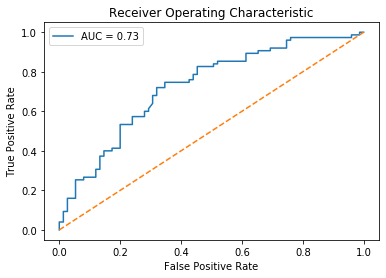

In [7]:
# predict probabilities for X_test using predict_proba
probabilities = svm.predict_proba(X_test)

# select the probabilities for label 1.0
y_proba = probabilities[:,1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');